In [1]:
import cv2, os, shutil, PIL
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Obtain the images

We are going to copy the files directly from Kaggle to our Google Drive without downloading to our local drive first. This requires generating an API key on Kaggle and then uploading that key to the top directory where you want the files to be transferred. Google Colab runtime comes with the Kaggle library pre-installed, but we need to use a shell command.

In [ ]:
#path to the json config file as an environment variable
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
%cd /content/drive/My Drive/Kaggle
!kaggle datasets download -d kmader/food41

# Explore the data

We use Pathlib, similar to os, to get the paths to each of thee images and then count them. We expect 101,000 per the documentation.

In [7]:
#get full path of all kaggle images
kaggle_dir = "/content/drive/MyDrive/kaggle/images"
kaggle_img_paths = list(Path(kaggle_dir).glob('*/*.jpg'))
ds_size = len(kaggle_img_paths)
print(f'Example Path: {kaggle_img_paths[0]} Total Paths: {ds_size}')

Example Path: /content/drive/MyDrive/kaggle/images/apple_pie/1200079.jpg Total Paths: 101000


We'll get the paths to all of the image subdirectories and count them. We expect 100. We will use these paths later to display images.

In [8]:
#get full path of all kaggle subdirectories
kaggle_img_dir, kaggle_sub_dirs, _  = next(os.walk(kaggle_dir))
kaggle_sub_paths = [os.path.join(kaggle_img_dir, subdir)for subdir in kaggle_sub_dirs]
print(f'Example Path: {kaggle_sub_paths[0]} Total Paths: {len(kaggle_sub_paths)}')

Example Path: /content/drive/MyDrive/kaggle/images/apple_pie Total Paths: 101


Below we arbitrarily take the first image from the first 9 directories. For tidiness, we'll resize them and display them in a 3x3 matrix. The images will be read in using cv2, so we need to convert to RGB before we display them using matplotlib.

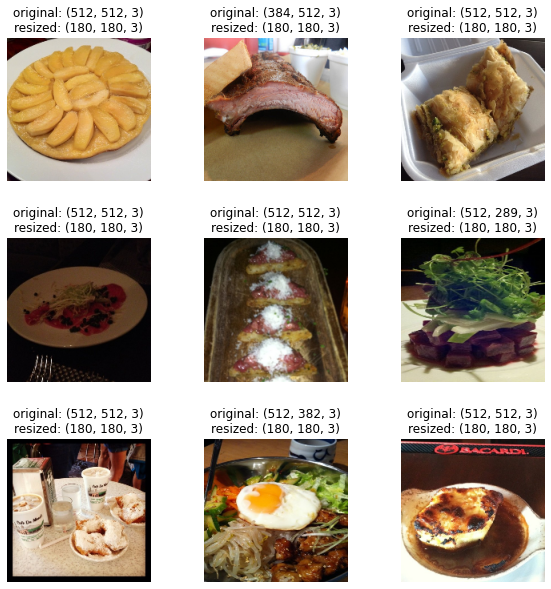

In [9]:
#show the first image from the first 9 classes
plt.figure(figsize = (10,10))
for i, path in enumerate(kaggle_sub_paths[:9]):
  img_path = list(Path(path).glob('*.jpg'))[0]
  img_pic = cv2.imread(str(img_path))
  # resize to 180x180
  img_res = cv2.resize(img_pic, dsize=(180,180))
  # reverse the color order
  img_rgb = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
  # create a 3x3 array of subplots
  plt.subplot(3,3, i+1)
  # display the image
  plt.imshow(img_rgb)
  # turn off the axis
  plt.axis('off')
  # add title
  plt.title(f"original: {img_pic.shape}\nresized: {img_res.shape}")
  # extra padding on the bottom
  plt.subplots_adjust(hspace=0.4)
  

# Divide the datasets

The Kaggle download came with additional assets. The two we will need are the train.txt and test.txt. These files contain the list of images that should be in the train dataset and the test dataset, respectively. The Kaggle project likely provided these for convenience and repeatability. Otherwise we would have to randomly sample the data ourselves.

In [10]:
#the text files contain the images that should go into each dataset test or train
os.listdir("/content/drive/MyDrive/kaggle/meta/meta")

['train.txt',
 'train.json',
 'test.json',
 'labels.txt',
 'classes.txt',
 'test.txt']

Later in this project we will read the train and test images directly into a preprocessing pipeline. Additionally, to save training time, we are not going to use the entire set of images. Instead, we are going to sample only a few classes. So in the next step, we are going to read in the text files, create a dataframe, and the select only 3 classes.

In [54]:
#read in the test text file as a dataframe
#get all the line items that have pizza, omlette, or samosa
food_list = ["omelette", "pizza", "samosa"]
txt_path = '/content/drive/MyDrive/kaggle/meta/meta/test.txt'
classes_images = defaultdict(list)
with open(txt_path, 'r') as txt:
  paths = [read.strip() for read in txt.readlines()]
  for p in paths:
    food = p.split('/')
    classes_images[food[0]].append(food[1] + '.jpg')
df_test = pd.DataFrame(classes_images)
df_test_mini = df_test.loc[:, food_list]
df_test_mini.head()

,omelette,pizza,samosa
0,1019294.jpg,1001116.jpg,1009326.jpg
1,1058816.jpg,1032754.jpg,1024186.jpg
2,1116874.jpg,103708.jpg,1036216.jpg
3,1122818.jpg,1060407.jpg,103689.jpg
4,1145379.jpg,106507.jpg,1052427.jpg


In [14]:
#read in the train text file as a dataframe
#get all the line items that have pizza, omlette, or samosa
txt_path = '/content/drive/MyDrive/kaggle/meta/meta/train.txt'
classes_images = defaultdict(list)
with open(txt_path, 'r') as txt:
  paths = [read.strip() for read in txt.readlines()]
  for p in paths:
    food = p.split('/')
    classes_images[food[0]].append(food[1] + '.jpg')
df_train = pd.DataFrame(classes_images)
df_train_mini = df_train.loc[:, food_list]
df_train_mini.head()

,omelette,pizza,samosa
0,1001719.jpg,1008104.jpg,1008131.jpg
1,1007843.jpg,1008144.jpg,1011601.jpg
2,1015300.jpg,1008844.jpg,101365.jpg
3,1029915.jpg,1008941.jpg,1015943.jpg
4,1038109.jpg,1011404.jpg,1016296.jpg


Below, we choose 3 classes and save a copy of those files. We'll save them to Google Drive rather than the local drive because it is much much faster so this only has to be done once. Below we read in the text files, select 3 classes, and create a dataframe. 

In [3]:
top_dir = "/content/drive/MyDrive/Colab Notebooks/food-101"

In [25]:
#make the destination directories
data_dirs = ["test", "train"]
for dir in data_dirs:
  for food in food_list:
    dst_dir = os.path.join(top_dir, dir, food)
    os.makedirs(dst_dir)

In [17]:
#define a function to iterate over the df and copy the files to a local dir
def copy_to_local(df, dataset):
  for col in tqdm(df.columns, desc='overall progress'):
    imgs = list(df[col])
    for row in imgs:
      src = os.path.join(kaggle_dir, col, row)
      dst = os.path.join(top_dir, dataset, col, row)
      shutil.copyfile(src, dst)

In [26]:
#copy the training images
copy_to_local(df_train_mini, "train")
#copy the test images
copy_to_local(df_test_mini, "test")

overall progress: 100%|██████████| 3/3 [00:10<00:00,  3.51s/it]


# Make the preprocessing pipeline

In [4]:
#confirm the test and train samples sizes
train_path = os.path.join(top_dir, "train")
test_path = os.path.join(top_dir, "test")
train_files = sum([len(files) for i, j, files in os.walk(train_path)])
test_files = sum([len(files) for i, j, files in os.walk(test_path)])
print(f"Train samples: {train_files} Test sample: {test_files}")

Train samples: 2250 Test sample: 750


In [5]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

Below is our preprocessing pipeline. We use the ImageDataGenerator class to augment the dataset. The preprocessing function inception_v3.preprocess_input scales input pixels to be between -1 and 1; and then shear, zoom, and flip are applied. We access the test and train image directories directly using flow_from_directory method of this class.

In [6]:
width, height = 299, 299
batch_size = 16

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


# Make the CNN

We are going to train several models. Each will use a different well known architecture as the base model for transfer learning. We will use ResNet50, VGG19, and InceptionV3. 

The base model is initialized with imagenet weights. Its output is specified as the input to the rest of the neural network, specifically it is the input to the next pooling layer. Pooling is required at the next layer to reshape the output of the pre-trained model.

The remaining layers of the network are a hidden fully connected layer, a drop-out layer, and then finally an output layer with a softmax activation function.

In [53]:
#we will save training weights, trained model, and training history
training_dirs = ["resnet50", "vgg19", "inceptionv3"]
for dir in training_dirs:
  path = os.path.join(top_dir, dir)
  os.mkdir(path)

In [8]:
#change the arc after every experiment to save the files to the right directory
arc = "inceptionv3"
best_model = os.path.join(top_dir, arc, 'best_model.hdf5')
trained_model = os.path.join(top_dir, arc, 'trained_model.hdf5')
history_log = os.path.join(top_dir, arc, 'history.log')
plot_model = os.path.join(top_dir, arc, 'plot_model.png')

In [9]:
#https://www.kaggle.com/code/theimgclist/multiclass-food-classification-using-tensorflow
def train_model(n_classes, num_epochs, train_samples, val_samples):
  K.clear_session()

  # create the base pre-trained model
  base_model = InceptionV3(weights='imagenet', include_top=False)
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer and dropout
  x = Dense(128,activation ='relu')(x)
  x = Dropout(0.2)(x)

  # and a logistic layer -- we have n_classes
  predictions = Dense(
      n_classes,
      #https://keras.io/api/layers/regularizers/
      kernel_regularizer = regularizers.l2(0.005),
      activation ='softmax')(x)

  #instantiate the model
  #https://keras.io/api/models/model/#model-class
  model = Model(inputs = base_model.input, outputs = predictions)
  model.compile(
      optimizer = SGD(lr = 0.0001, momentum = 0.9),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy'])
  
  #save model or weights so it can be loaded later to continue the training
  #https://keras.io/api/callbacks/model_checkpoint/
  checkpoint = ModelCheckpoint(
      filepath = best_model,
      verbose = 1,
      save_best_only = True)
  
  #save results as a csv file
  #https://keras.io/api/callbacks/csv_logger/
  csv_logger = CSVLogger(history_log)

  history = model.fit(
                      train_generator,
                      steps_per_epoch = train_samples // batch_size,
                      validation_data = validation_generator,
                      validation_steps = val_samples // batch_size,
                      epochs = num_epochs,
                      verbose = 1,
                      callbacks = [csv_logger, checkpoint])

  #save the trained model
  model.save(trained_model)

  class_map = train_generator.class_indices 
  
  return history, class_map

# Train the model

In [45]:
# Train the model with data from 3 classes
n_classes = 3
epochs = 4
train_samples = train_files
val_samples = test_files

history, class_map_3 = train_model(n_classes, epochs, train_samples, val_samples)
print(class_map_3)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-11-902ee907b122>:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/4
140/140 [==============================] - ETA: 0s - loss: 1.0324 - accuracy: 0.4969
Epoch 1: val_loss improved from inf to 0.75359, saving model to /content/drive/MyDrive/Colab Notebooks/food-101/inceptionv3/best_model.hdf5
140/140 [==============================] - 85s 600ms/step - loss: 1.0324 - accuracy: 0.4969 - val_loss: 0.7536 - val_accuracy: 0.7364
Epoch 2/4
140/140 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.6822
Epoch 2: val_loss improved from 0.75359 to 0.51208, saving model to /content/drive/MyDrive/Colab Notebooks/food-101/inceptionv3/best_model.hdf5
140/140 [==============================] - 83s 594ms/step - loss: 0.7288 - accuracy: 0.6822 - val_loss: 0.5121 - val_accuracy: 0.8234
Epoch 3/4
140/140 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7677
Epoch 3: val_loss improved from 0.51208 to 0.45215, saving model to /content/drive/MyDrive/Colab Notebooks/food-101/inceptionv3/best_model.hdf5
140/140 [==========

# View the results

The results of training were streamed to a CSV file. We can load that CSV file to view how accuracy and loss improved over time.

In [20]:
history = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/food-101/vgg19/history.log')
history.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.517905,1.008458,0.735054,0.733083
1,1,0.690242,0.723207,0.800272,0.513994
2,2,0.754252,0.604020,0.774457,0.538756
3,3,0.802596,0.529883,0.862772,0.383265


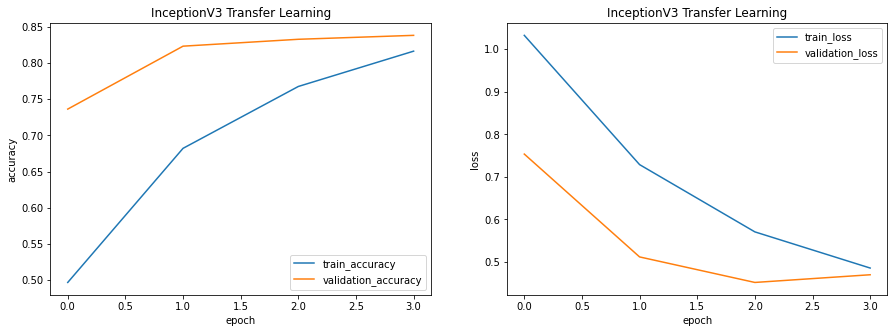

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('InceptionV3 Transfer Learning')
ax1.plot(history['accuracy'])
ax1.plot(history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_accuracy', 'validation_accuracy'], loc='best');

ax2.set_title('InceptionV3 Transfer Learning')
ax2.plot(history['loss'])
ax2.plot(history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train_loss', 'validation_loss'], loc='best');

In [49]:
fig.savefig('/content/drive/MyDrive/Colab Notebooks/food-101/inceptionv3/figure_1.png')

# Make a prediction

Below we download a random image of a samosa from the web. We load a saved InceptionV3 model and we call the prediction method on it. It will return probabilities for all 3 classes and the class with the highest probability should be samosa.

In [12]:
saved_model = load_model(trained_model)

1/1 [==============================] - 0s 20ms/step
The image is a picture of samosa.


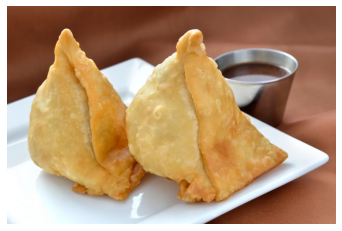

In [69]:
x = PIL.Image.open('/content/Samosas-H.webp')
plt.imshow(x)
plt.axis('off')
x = np.array(image)
x = np.expand_dims(x, axis=0)
y = saved_model.predict(x)
y = list(y[0])
maximum = max(y)
i = y.index(maximum)
print(f"The image is a picture of {food_list[i]}.")

# Diagram model

The trained model was also saved. We can load it and plot a diagram of it. This will enable us to compare model architectures visually.

In [ ]:
tf.keras.utils.plot_model(
    saved_model,
    to_file=plot_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
);

In [52]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/Copy of Final Assignment Food101.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Copy of Final Assignment Food101.ipynb to html
[NbConvertApp] Writing 914792 bytes to /content/drive/MyDrive/Colab Notebooks/Copy of Final Assignment Food101.html
